# 等职线图


In [5]:
#coding=utf-8
from scipy.interpolate import griddata
import matplotlib as mpl
from math import ceil, floor
from rasterio import features
from affine import Affine
import numpy as np
import xarray as xr
import pandas as pd
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
# from osgeo import gdal
import cartopy.crs as ccrs
import shapefile
from matplotlib.font_manager import FontProperties
# import netCDF4 as nc
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from math import isnan
import geopandas as gpd
from ncmaps import Cmaps
# print("666")
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da


def basemask(cs, ax, map, shpfile):

    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)    
    for contour in cs.collections:
        contour.set_clip_path(clip)    



def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels


def plot_image(lat,lon,value):
    #线性插值
    N = len(value)
    a = []
    b = []
    z = []
    for i in range(N):
        if value[i]!=-9999.0:
            a.append(round(lon[i],2))
            b.append(round(lat[i],2))
            z.append(round(value[i],2))
    lat = np.array(b)
    lon = np.array(a)
    Zi = np.array(z)
    data_max = max(Zi)
    data_min = min(Zi)
    np.set_printoptions(precision = 2)
    x = np.arange(120.0,122.0,0.05)
    #print(x)
    y = np.arange(27.8,29.5,0.05)
    nx0 =len(x)
    ny0 =len(y)
    X, Y = np.meshgrid(x, y)#100*100
    P = np.array([X.flatten(), Y.flatten() ]).transpose()    
    Pi =  np.array([lon, lat ]).transpose()
    Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
    #绘图
    levels = np.linspace(start = data_min/10.0, stop = data_max/10.0, num = 7)
    self_define_list = [130,144,155,170,185,200,225,235,240,244]
    rgb_file = 'ncl_default'
    #以下是核心api,实质为调用Cmaps基类的listmap()方法
    cmaps = Cmaps('ncl_default',self_define_list).listmap()
    # plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=[12,16]) 
    
    ax = fig.add_subplot(111)
    # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    filepath = "static/data/shpfile/"
    data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
    shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
    awash_da = shp_da.where(shp_da.test<7, other=np.nan)
    m = Basemap(llcrnrlon=120.0,llcrnrlat=27.8,urcrnrlon=122,urcrnrlat=29.5,resolution = None, projection = 'cyl')
    # 设置colorbar
    cbar_kwargs = {'shrink': 0.5}    
    cs = data_xr.plot.contourf(ax=ax, cmap='Spectral_r',levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
    m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
    parallels = np.arange(27.8,29.5,0.2)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
    meridians = np.arange(120.0,122.0,0.2)
    m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
    len_lat = len(data_xr.lat.data)
    len_lon = len(data_xr.lon.data)
    for i in range(len_lon-1):
        for j in range(len_lat-1):
            y0 = round(27.8+j*0.05,2)
            x0 = round(120.0+i*0.05,2)
            if not isnan(awash_da.data[j,i]):
                plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
    basemask(cs, ax, m, filepath+'taizhou')  
    


In [14]:
pwd!


'/workspace/liyuan3970/Data/My_Git/web_met/static/data'

In [3]:
import netCDF4 
file = r'/workspace/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/20220401/test.nc'
f = netCDF4.Dataset(file)
lat = f.variables['lat']
lat

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    long_name: Latitude
unlimited dimensions: 
current shape = (47,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
import xarray as xr
file = 'TZ_self/20220401/I20220401200000.T.nc'
f = xr.open_dataset(file)

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


OSError: [Errno -101] NetCDF: HDF error: b'/workspace/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/20220401/I20220401200000.T.nc'

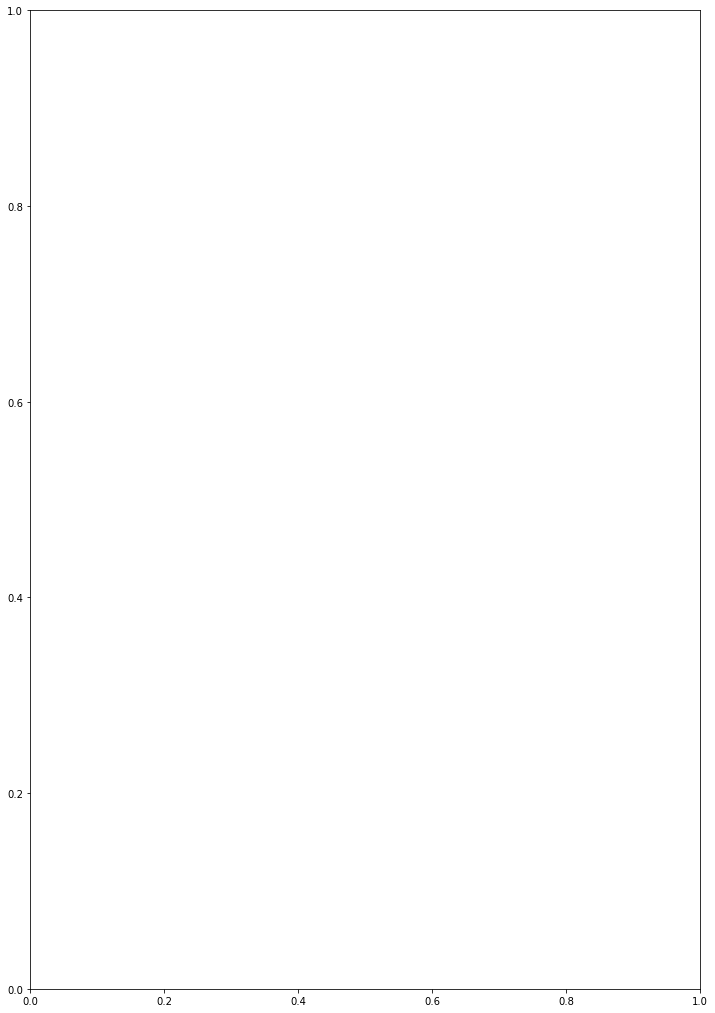

In [8]:
#coding=utf-8
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
#from osgeo import gdal
import numpy as np
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib
from math import isnan
import geopandas as gpd

from ncmaps import Cmaps

levels = np.linspace(start = 0, stop = 30, num = 7)#[10,20,30,40,50,60,70,80,90,100,110]


self_define_list = [130,144,155,170,185,200,225,235,240,244]
rgb_file = 'ncl_default'
#以下是核心api,实质为调用Cmaps基类的listmap()方法
cmaps = Cmaps('ncl_default',self_define_list).listmap()

# plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[12,18]) 
ax = fig.add_subplot(111)


def basemask(cs, ax, map, shpfile):

    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)    
    for contour in cs.collections:
        contour.set_clip_path(clip)    



def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels
filepath = "/home/liyuan3970/study_demo/met_plot/Basemap/"
# print(Z_linear.shape,x.shape)
file = 'TZ_self/20220401/I20220401200000.T.nc'
f = xr.open_dataset(file)
print(f)
# data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
#                     dims=["lat", "lon"])
# data_xr = xr.DataArray(Z_linear.reshape([nx0,ny0]), coords=[ x,y], 
#                     dims=["lon", "lat"])
# shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
# awash_da = shp_da.where(shp_da.test<7, other=np.nan)

# m = Basemap(llcrnrlon=120.0,
#     llcrnrlat=27.8,
#     urcrnrlon=122,
#     urcrnrlat=29.5,
#     resolution = None, 
#     projection = 'cyl')


# # 设置colorbar
# cbar_kwargs = {
# #'orientation': 'horizontal',
# # 'label': 'Potential',
# 'shrink': 0.5,
# }


# cs = data_xr.plot.contourf(ax=ax, cmap='Spectral_r',levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
# # cs = data_xr.plot(ax=ax, cmap='Spectral_r',levels =levels )
# cs?

# m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
# # plt.text(120.2,29.4,data_xr.data[0,1],fontsize= 6 ,color ="r")

# parallels = np.arange(27.8,29.5,0.2)
# # labels = [left,right,top,bottom]
# m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
# meridians = np.arange(120.0,122.0,0.2)
# m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
# # plt.rcParams.update({'font.size':25})

# print("shape:",data_xr.shape)        
# print("type::",type(data_xr.data[0,1]),data_xr.data[0,1])    

# len_lat = len(data_xr.lat.data)
# len_lon = len(data_xr.lon.data)
# print("len:",len_lat,len_lon)
# print("lon:",data_xr.lon.data)
# print("lat:",data_xr.lat.data)
# # for i in range(len_lon-1):
# #     for j in range(len_lat-1):
# #         y0 = round(27.8+j*0.05,2)
# #         x0 = round(120.0+i*0.05,2)
# # #         print("66666",x0,y0,i,j)
# #         if not isnan(data_xr.data[j,i]):
# #             plt.text(x0,y0,str(round(data_xr.data[j,i],0)),fontsize= 4 ,color ="blue")

# for i in range(len_lon-1):
#     for j in range(len_lat-1):
#         y0 = round(27.8+j*0.05,2)
#         x0 = round(120.0+i*0.05,2)
# #         print("66666",x0,y0,i,j)
#         if not isnan(awash_da.data[j,i]):
#             plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
#             #plt.text(x0,y0,str(round(awash_da.data[j,i],1)),fontsize= 8 ,color ="blue")
# basemask(cs, ax, m, filepath+'taizhou')  